##Loading Data
load google drive.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


get directories.

In [0]:
import os

# Directory with training bat pictures
train_bat_dir = os.path.join('./drive/My Drive/dataset/bat-or-human/bats')

# Directory with training human pictures
train_human_dir = os.path.join('./drive/My Drive/dataset/bat-or-human/humans')

total number of bat and human images in the directories.

In [0]:
train_bat_names = os.listdir(train_bat_dir)
train_human_names = os.listdir(train_human_dir)

print('total training bat images:', len(os.listdir(train_bat_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training bat images: 377
total training human images: 424


show pictures.

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

display a batch of 8 bat and 8 human pictures.

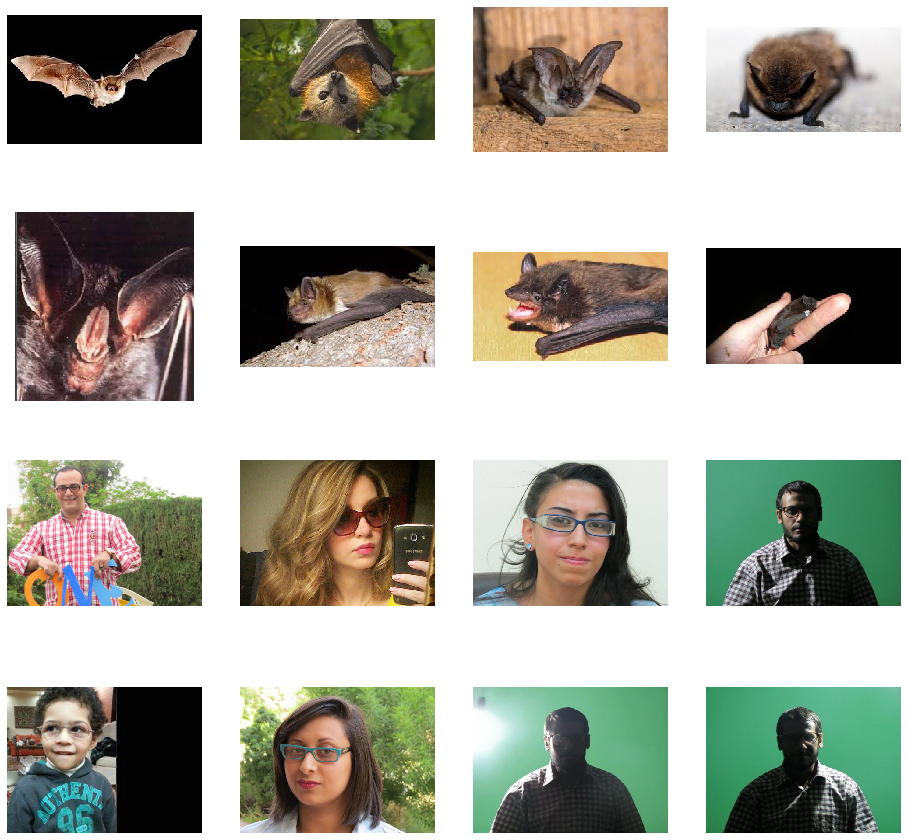

In [0]:
# Set up matplotlib fig, and resize it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

next_bat_pix = [os.path.join(train_bat_dir, fname) 
                for fname in train_bat_names[0:8]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[0:8]]

for i, img_path in enumerate(next_bat_pix+next_human_pix):
  # Set up subplot, indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()


## Building Model

import tensorflow.

In [0]:
import tensorflow as tf

CNN graph.

In [0]:
model = tf.keras.models.Sequential([
    # convolution layers
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron, 0-1.
    tf.keras.layers.Dense(1, activation='sigmoid')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


model summary.

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

loss, optimizer, metrics specification.

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Data Preprocessing

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 128
train_generator = train_datagen.flow_from_directory(
        './drive/My Drive/dataset/bat-or-human/',
        target_size=(300, 300),
        batch_size=128,
        class_mode='binary')

print(train_generator.class_indices)

Found 800 images belonging to 2 classes.
{'bats': 0, 'humans': 1}


### Training
callbacks, allow model to stop once acc is over 95%

In [0]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('acc') > 0.95):
            print("Reached 95.0% accuracy, training is stopped")
            self.model.stop_training = True

train for 15 epochs, but if acc of 95.0% is reached, training will be stoped.

In [0]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=10,  
      epochs=15,
      verbose=1,
      callbacks=[myCallback()])

Epoch 1/15
10/10 [==============================] - 243s 24s/step - loss: 0.7642 - acc: 0.5329
Epoch 2/15
10/10 [==============================] - 5s 535ms/step - loss: 0.5403 - acc: 0.7454
Epoch 3/15
10/10 [==============================] - 5s 523ms/step - loss: 0.4733 - acc: 0.7638
Epoch 4/15
10/10 [==============================] - 6s 593ms/step - loss: 0.4655 - acc: 0.7593
Epoch 5/15
10/10 [==============================] - 6s 577ms/step - loss: 0.4388 - acc: 0.7745
Epoch 6/15
10/10 [==============================] - 5s 507ms/step - loss: 0.4316 - acc: 0.7868
Epoch 7/15
10/10 [==============================] - 6s 584ms/step - loss: 0.3901 - acc: 0.8074
Epoch 8/15
10/10 [==============================] - 6s 597ms/step - loss: 0.3355 - acc: 0.8471
Epoch 9/15
10/10 [==============================] - 5s 544ms/step - loss: 0.3137 - acc: 0.8493
Epoch 10/15
10/10 [==============================] - 6s 588ms/step - loss: 0.2558 - acc: 0.8894
Epoch 11/15
10/10 [==============================

###Running the Model

upload and predict.

Saving bat.jpeg to bat.jpeg
Saving trump.jpg to trump.jpg
[0.]
bat.jpeg is a bat
prediction 1 costs 0.19010114669799805 seconds
[1.]
trump.jpg is a human
prediction 2 costs 0.004960536956787109 seconds


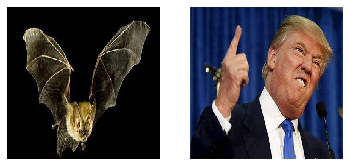

In [0]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import time

uploaded = files.upload()
count = 1

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  
  # show the image predicted
  sp = plt.subplot(1, 2, count)
  sp.axis('Off')
  plt.imshow(img)

  timer_1 = time.time()

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a bat")
  
  timer_2 = time.time()

  print("prediction", count, "costs", timer_2-timer_1, "seconds")
  count += 1

## Clean Up

In [0]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)